In [ ]:
%%writefile prueba1.cpp
#include <stdio.h>
#include <stdlib.h>
#include<iostream> 
using namespace std;
int main (int argc, char **argv) {    
    int n = atoi(argv[1]);

    cout << "n="<< n;
    return 0;
}

Writing prueba1.cpp


In [ ]:
%%script bash
g++ prueba1.cpp -o prueba1
./prueba1 100

n=100

In [ ]:
%%writefile prueba2.c
#include <stdio.h>
#include <stdlib.h>
//#include<iostream> 
//using namespace std;
int main (int argc, char **argv) {    
    int n = atoi(argv[1]);

    //cout << "n="<< n;
    printf("n=%d",n);
    return 0;
}

Writing prueba2.c


In [ ]:
%%script bash
g++ prueba2.c -o prueba2
./prueba2 100

n=100

Contar el numero de primos en [1,n]

In [ ]:
%%writefile Primos.c
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <sys/time.h>

float time_diff(struct timeval *start, struct timeval *end){
    return (end->tv_sec - start->tv_sec) + 1e-6*(end->tv_usec - start->tv_usec);
}

int main(int argc, char **argv) {
    
    int n = atoi(argv[1]);
    time_t Inicio = time(NULL);

    struct timeval start;
    struct timeval end;    

    gettimeofday(&start, NULL);// <----- tiempo1
    
    int valoracion = 0;
    for (int i = 2; i <=n;i++){
        int flag = 0;
        for (int j = 2; j <= i/2; j++){
            if(i % j == 0){
              flag = 1;
                break;
            }
        }
        if(flag == 0){
          //printf("%d es un numero primo\n",i);
          valoracion++;
        }        
    }
    int total = 0;
    if(total == 0){
        for(int i = 0 ; i < n; i++){   
            total = valoracion;     
        }
        printf("\nTotal de Numeros primos: %d\n", total);
    } 

    gettimeofday(&end, NULL); // <----- tiempo2

    printf("Tiempo ejecutado en: %f segundos",time_diff(&start, &end));
    
    //time_t Final = time(NULL);
    //printf("Tiempo ejecutado en %d segundos", int(Final - Inicio));
    return 0;
}

Writing Primos.c


In [ ]:
%%script bash
g++ Primos.c -o Primos
./Primos 2000000


Total de Numeros primos: 148933
Tiempo ejecutado en: 348.165222 segundos



---



In [ ]:
%%writefile PrimosVersión1.c
#include "mpi.h"
#include <stdio.h>
#include <stdlib.h>

#define BLOCK_LOW(id,p,n) ((id)*(n)/(p))
#define BLOCK_HIGH(id,p,n)(BLOCK_LOW((id)+1,p,n)-1)
#define BLOCK_SIZE(id,p,n)(BLOCK_HIGH(id,p,n)-BLOCK_LOW(id,p,n)+1)

int main (int argc, char **argv) {
  MPI_Init(&argc, &argv);
  int id, i, np, n, inicio, fin, num_elems_rango,root = 0;

  // Para calcular los tiempos
  double t1,t2;

  MPI_Comm_size(MPI_COMM_WORLD, &np); // Numero total de procesos
  MPI_Comm_rank(MPI_COMM_WORLD, &id); // Valor de nuestro identificador
    
    n = atoi(argv[1]);
    inicio = BLOCK_LOW(id,np,n)+1; // para que empiece en 1
    fin    = BLOCK_HIGH(id,np,n)+1;
    num_elems_rango = BLOCK_SIZE(id,np,n);

    MPI_Barrier(MPI_COMM_WORLD);  // sincronización
    t1 = MPI_Wtime();

    if(id == 0){
        printf("Programa encuentra el numero de primos menores o iguales a %d\n",n);
    }

    int valoracion = 0;
    for (int i = inicio; i <= fin; i++){
        int flag = 0;
        for (int j = 2; j <= i/2; j++){
            if(i % j == 0){
              flag = 1;
                break;
            }
        }
        if (flag == 0 && i != 1){
            //printf("%d es un numero primo\n",i);
            valoracion++;
        }
    }

    MPI_Send(&valoracion, 1, MPI_INT, root, 9, MPI_COMM_WORLD);

    int total = 0;
    if(id == root){
        for(i = 0 ; i < np ; i++){
            MPI_Recv(&valoracion, 1, MPI_INT, i, 9, MPI_COMM_WORLD, MPI_STATUS_IGNORE);     
            total += valoracion;     
        }
        printf("\nNumeros primos totales: %d\n", total);
    } 

    MPI_Barrier(MPI_COMM_WORLD);  // sincronización
    t2 = MPI_Wtime();

    if(id == 0){
      printf("Numero de procesos: %d, Tiempo ejecutado en: %.10f \n",np, t2-t1);
      //printf("\nTiempo total al calcular la cantidad de numeros primos fue: %.10f segundos \n", t2-t1);
    }

    MPI_Finalize(); 
}

Overwriting PrimosVersión1.c


In [ ]:
%%script bash
mpicc PrimosVersión1.c -o PrimosVersión1
mpirun --allow-run-as-root -np 15 PrimosVersión1 2000000

Programa encuentra el numero de primos menores o iguales a 2000000

Numeros primos totales: 148933
Numero de procesos: 15, Tiempo ejecutado en: 462.2458422700 


In [4]:
%%writefile PrimosVersión2.c
#include "mpi.h"
#include <stdio.h>
#include <stdlib.h>

#define BLOCK_LOW(id,p,n) ((id)*(n)/(p))
#define BLOCK_HIGH(id,p,n) (BLOCK_LOW((id)+1,p,n)-1)
#define BLOCK_SIZE(id,p,n)(BLOCK_HIGH(id,p,n)-BLOCK_LOW(id,p,n)+1)

int main (int argc, char **argv) {
  MPI_Init(&argc, &argv);
  int id, i, np, n, inicio, fin, num_elems_rango,root = 0, sendbuf, recvbuf;

  // Para calcular los tiempos
  double t1,t2;

  MPI_Comm_size(MPI_COMM_WORLD, &np); // Numero total de procesos
  MPI_Comm_rank(MPI_COMM_WORLD, &id); // Valor de nuestro identificador
    
    n = atoi(argv[1]);
    inicio = BLOCK_LOW(id,np,n)+1; // para que empiece en 1
    fin    = BLOCK_HIGH(id,np,n)+1;
    num_elems_rango = BLOCK_SIZE(id,np,n);

    MPI_Barrier(MPI_COMM_WORLD);  // sincronización
    t1 = MPI_Wtime();

    if(id == 0){
        printf("Programa encuentra el numero de primos menores o iguales a %d\n",n);
    }

    int valoracion = 0;
    for (int i = inicio; i <= fin; i++){
        int flag = 0;
        for (int j = 2; j <= i/2; j++){
            if(i % j == 0){
              flag = 1;
                break;
            }
        }
        if(flag == 0 && i != 1){
            //printf("%d es un numero primo\n",i);
            valoracion++;
        }
    }
    sendbuf = valoracion;
    MPI_Reduce(&sendbuf, &recvbuf, 1, MPI_INT, MPI_SUM, root, MPI_COMM_WORLD);

    //MPI_Send(&valoracion, 1, MPI_INT, root, 9, MPI_COMM_WORLD);

    //int total = 0;
    if(id == root){
      printf("\nNumero de primos totales: %d \n", recvbuf);
        //for(i = 0 ; i < np ; i++){
            //MPI_Recv(&valoracion, 1, MPI_INT, i, 9, MPI_COMM_WORLD, MPI_STATUS_IGNORE);     
            //total += valoracion;     
    //   }
    } 

    MPI_Barrier(MPI_COMM_WORLD);  // sincronización
    t2 = MPI_Wtime();

    if(id == 0){
       printf("Numero de procesos: %d, Tiempo ejecutado en: %.10f \n",np, t2-t1);
       //printf("\nTiempo total al calcular la cantidad de numeros primos fue: %.10f segundos \n", t2-t1);
    }
 
    MPI_Finalize(); 
}

Overwriting PrimosVersión2.c


In [5]:
%%script bash
mpicc PrimosVersión2.c -o PrimosVersión2
mpirun --allow-run-as-root -np 15 PrimosVersión2 10000

Programa encuentra el numero de primos menores o iguales a 10000

Numero de primos totales: 1229 
Numero de procesos: 15, Tiempo ejecutado en: 0.0108213700 


In [ ]:
%matplotlib inline

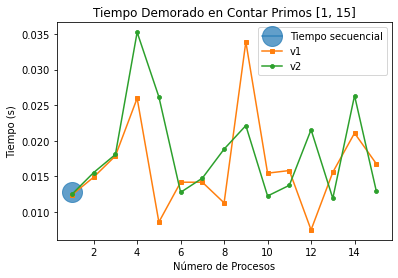

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
tiempo_secuencial = 0.012845

procesos = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

tiempos_ms_v1 = np.array([0.0124099030,0.0149031840,0.0178839070,0.0259744120,0.0085985290,
                          0.0141937580,0.0141937580,0.0112948700,0.0338958240,0.0154648400,
                          0.0158324030,0.0075012030,0.0155936330,0.0210862540,0.0167910930])

tiempos_ms_v2 = np.array([0.0124988120,0.0155509340,0.0180866250,0.0352389340,0.0261691810,
                          0.0127759650,0.0147653510,0.0188423790,0.0221430700,0.0122632460,
                          0.0137585770,0.0215604370,0.0119300750,0.0263472120,0.0129667000])

fig, ax = plt.subplots()

ax.plot([1],[tiempo_secuencial],marker='o',markersize=20,alpha=0.7,label='Tiempo secuencial')
ax.plot(procesos,tiempos_ms_v1,marker = 's',markersize = 4,label="v1")
ax.plot(procesos,tiempos_ms_v2,marker = '8',markersize = 4,label="v2")

plt.xlabel('Número de Procesos')
plt.ylabel('Tiempo (s)')
plt.title('Tiempo Demorado en Contar Primos [1, 15]')
plt.legend()
plt.show()

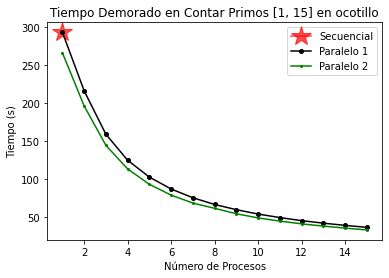

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
tiempo_secuencial = 293.229858

procesos = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

tiempos_ms_v1 = np.array([293.2190065831,216.1276451424,159.0311161578,124.8287680782,102.6891115904,
                          87.0490396842,75.5162158161,66.6912076063,59.8205076680,54.0941090845,
                          49.4361173511,45.4080553241,42.1178614870,39.1770227179,36.5793791451])

tiempos_ms_v2 = np.array([266.1675441787,196.2425972149,144.4431416988,113.3936273716,93.1795265190,
                          78.9735013954,68.5266097449,61.6395311095,54.4364807308,49.0172179602,
                          44.7914064750,41.1850959919,38.2212208770,35.5565741360,33.2019211650])

fig, ax = plt.subplots()
ax.plot([1],[tiempo_secuencial],marker='*',markersize=20,alpha=0.7,color='r', label='Secuencial')
ax.plot(procesos,tiempos_ms_v1,marker = 'o',markersize = 4,color='k',label="Paralelo 1")
ax.plot(procesos,tiempos_ms_v2,marker = '.',markersize = 4,color='g',label="Paralelo 2")

plt.xlabel('Número de Procesos')
plt.ylabel('Tiempo (s)')
plt.title('Tiempo Demorado en Contar Primos [1, 15] en ocotillo')
plt.legend()
plt.show()